In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt
import pandas as pd
import os
#import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_dir = '/Users/qihou/HAM10000_train'
test_dir = '/Users/qihou/HAM10000_test'

In [133]:
train_datagen = ImageDataGenerator(rescale = 1/255) 
test_datagen = ImageDataGenerator(rescale = 1/255)

train_gen = train_datagen.flow_from_directory(train_dir, batch_size=8, target_size = (299, 299))
test_gen = test_datagen.flow_from_directory(test_dir, batch_size=8, target_size = (299, 299))

Found 8012 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [5]:
df = pd.read_csv('/Users/qihou/HAM10000_metadata.csv')

In [26]:
os.listdir(train_dir + '/mel')

['ISIC_0028965.jpg',
 'ISIC_0032915.jpg',
 'ISIC_0024805.jpg',
 'ISIC_0030119.jpg',
 'ISIC_0025500.jpg',
 'ISIC_0033362.jpg',
 'ISIC_0026586.jpg',
 'ISIC_0034141.jpg',
 'ISIC_0026545.jpg',
 'ISIC_0030333.jpg',
 'ISIC_0033174.jpg',
 'ISIC_0027101.jpg',
 'ISIC_0027673.jpg',
 'ISIC_0030521.jpg',
 'ISIC_0028352.jpg',
 'ISIC_0032685.jpg',
 'ISIC_0030910.jpg',
 'ISIC_0032875.jpg',
 'ISIC_0029272.jpg',
 'ISIC_0024756.jpg',
 'ISIC_0032134.jpg',
 'ISIC_0027277.jpg',
 'ISIC_0033570.jpg',
 'ISIC_0033216.jpg',
 'ISIC_0025313.jpg',
 'ISIC_0033217.jpg',
 'ISIC_0034222.jpg',
 'ISIC_0032653.jpg',
 'ISIC_0033559.jpg',
 'ISIC_0034236.jpg',
 'ISIC_0032690.jpg',
 'ISIC_0024958.jpg',
 'ISIC_0032684.jpg',
 'ISIC_0027060.jpg',
 'ISIC_0033773.jpg',
 'ISIC_0025105.jpg',
 'ISIC_0033029.jpg',
 'ISIC_0030246.jpg',
 'ISIC_0034034.jpg',
 'ISIC_0033968.jpg',
 'ISIC_0028227.jpg',
 'ISIC_0033607.jpg',
 'ISIC_0033175.jpg',
 'ISIC_0026236.jpg',
 'ISIC_0032531.jpg',
 'ISIC_0028582.jpg',
 'ISIC_0034183.jpg',
 'ISIC_003340

In [27]:
os.listdir(train_dir)

['akiec', '.DS_Store', 'df', 'bkl', 'vasc', 'nv', 'bcc', 'mel']

In [134]:
x, y = next(train_gen)
x.shape, y.shape

((8, 299, 299, 3), (8, 7))

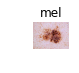

In [29]:
plt.subplot(7, 3, i+1)
for folder in os.listdir(train_dir):
    if folder != '.DS_Store':
        for i, path in enumerate(os.listdir(os.path.join(train_dir, folder))):
            if i < 3:
                img = imread(os.path.join(train_dir, folder, path))
                plt.imshow(img)
                plt.axis('off')
                plt.title(folder)
            else:
                break
                
#imgs = np.asarray(img)
#image.shape

## Transfer Learning with Model InceptionV3

In [120]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras

In [154]:
base_model = InceptionV3(include_top = False, weights = 'imagenet',input_shape = (299, 299, 3))

In [155]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 149, 149, 32) 96          conv2d_210[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_207[0][0]    
_______________________________________________________________________________________

In [156]:
base_model.output

<tf.Tensor 'mixed10_2/concat:0' shape=(?, 8, 8, 2048) dtype=float32>

In [158]:
x = base_model.output

x = tensorflow.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'Same')(x)

x = tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.MaxPool2D(pool_size=(4,4))(x)

x_flatten = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dropout(0.5)(x_flatten)
x = tensorflow.keras.layers.Dense(64, activation='relu')(x)

predictions = tf.keras.layers.Dense(7, activation='softmax')(x)

In [159]:
model_transfer = tf.keras.Model(base_model.input, predictions)

In [160]:
for layer in base_model.layers:
    layer.trainable = False

In [161]:
model_transfer.compile(optimizer = 'adam',
                       loss = 'categorical_crossentropy',
                       metrics = ['acc'])

In [163]:
model_transfer.fit_generator(
    train_gen,
    steps_per_epoch = len(train_gen),
    epochs = 20,
    validation_data = test_gen,
    validation_steps = len(test_gen),
    workers=4
)

Epoch 1/20
1002/1002 [==============================] - 668s 667ms/step - loss: 1.0934 - acc: 0.6613 - val_loss: 1.3197 - val_acc: 0.6680
Epoch 2/20
1002/1002 [==============================] - 661s 660ms/step - loss: 0.8818 - acc: 0.6978 - val_loss: 1.9570 - val_acc: 0.6680
Epoch 3/20
1002/1002 [==============================] - 670s 669ms/step - loss: 0.8266 - acc: 0.7102 - val_loss: 1.6197 - val_acc: 0.6690
Epoch 4/20
1002/1002 [==============================] - 664s 663ms/step - loss: 0.7893 - acc: 0.7218 - val_loss: 1.9433 - val_acc: 0.6690
Epoch 5/20
1002/1002 [==============================] - 706s 705ms/step - loss: 0.7658 - acc: 0.7282 - val_loss: 2.2266 - val_acc: 0.6695
Epoch 6/20
1002/1002 [==============================] - 686s 685ms/step - loss: 0.7417 - acc: 0.7363 - val_loss: 1.8254 - val_acc: 0.6710
Epoch 7/20
1002/1002 [==============================] - 692s 691ms/step - loss: 0.7351 - acc: 0.7401 - val_loss: 1.5612 - val_acc: 0.6730
Epoch 8/20
1002/1002 [============

KeyboardInterrupt: 

In [164]:
loss_test, acc_test = model_transfer.evaluate_generator(test_gen)

In [168]:
loss_train, acc_train = model_transfer.evaluate_generator(train_gen)

In [169]:
loss_train, acc_train

(1.7971047889928058, 0.6718672)

In [170]:
loss_test, acc_test

(1.8208047708610549, 0.669995)

## Transfer Learning with Model VGG16

In [101]:
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras
tensorflow.keras.__version__

'2.2.4-tf'

In [102]:
base_model_2 = VGG16(input_shape = (256, 256, 3), include_top = False, weights='imagenet')

In [103]:
base_model_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [104]:
base_model_2.output

<tf.Tensor 'block5_pool_6/MaxPool:0' shape=(?, 8, 8, 512) dtype=float32>

In [114]:
x = base_model_2.output
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
predictions_2 = tf.keras.layers.Dense(7, activation='softmax')(x)

In [116]:
model_transfer_2 = tf.keras.Model(base_model_2.input, predictions_2)

for layer in base_model.layers:
    layer.trainable = False
    
model_transfer.compile(optimizer = 'adam',
                       loss = 'categorical_crossentropy',
                       metrics = ['acc'])

In [117]:
model_transfer.fit_generator(
    train_gen,
    steps_per_epoch = len(train_gen),
    epochs = 20,
    validation_data = test_gen,
    validation_steps = len(test_gen),
    workers=4
)

Epoch 1/20
1336/1336 [==============================] - 823s 616ms/step - loss: 1.1419 - acc: 0.6699 - val_loss: 1.1537 - val_acc: 0.6680
Epoch 2/20
 738/1336 [===============>..............] - ETA: 4:56 - loss: 1.1679 - acc: 0.6563

KeyboardInterrupt: 

## Transfer Learning with MobileNetV2

In [106]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [107]:
base_model_3 = MobileNetV2(input_shape = (256, 256, 3), include_top = False, weights='imagenet')

In [108]:
base_model_3.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [109]:
base_model_3.output

<tf.Tensor 'out_relu_4/Relu6:0' shape=(?, 8, 8, 1280) dtype=float32>

In [110]:
x = base_model_3.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
predictions = tf.keras.layers.Dense(7, activation='softmax')(x)